In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import dump

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
train_norm = normaliser.fit_transform(train)
test_norm = normaliser.transform(test)

In [8]:
# Normalised train chunks
X_train = np.array([train_norm[i : i + backlook].copy() for i in range(len(train) - backlook)])
Y_train = np.array([train_norm[:,0][i + backlook].copy() for i in range(len(train) - backlook)])
Y_train = np.expand_dims(Y_train, -1)

In [9]:
# Normalised test chunks
X_test = np.array([test_norm[i : i + backlook].copy() for i in range(len(test) - backlook)])
Y_test = np.array([test_norm[:,0][i + backlook].copy() for i in range(len(test) - backlook)])
Y_test = np.expand_dims(Y_test, -1)

In [10]:
# Y raw data
next_day_open_values = np.array([train[:,0][i + backlook].copy() for i in range(len(train) - backlook)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.3303677 ],
       [0.32881229],
       [0.33814471],
       ...,
       [0.52547751],
       [0.51919368],
       [0.53300566]])

In [11]:
# Save scalers for future use
dump(normaliser, './normalisers/x_normaliser.joblib')
dump(y_normaliser, './normalisers/y_normaliser.joblib')

['./normalisers/y_normaliser.joblib']

# Model selection

##### Model constructor

In [12]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [13]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [14]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [15]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 3s 746us/step - loss: 0.0276 - val_loss: 0.0016
Epoch 2/24
4143/4143 [==============================] - 2s 478us/step - loss: 0.0264 - val_loss: 0.0494
Epoch 3/24
4143/4143 [==============================] - 2s 482us/step - loss: 0.0176 - val_loss: 7.9258e-04
Epoch 4/24
4143/4143 [==============================] - 2s 501us/step - loss: 0.0046 - val_loss: 0.0094
Epoch 5/24
4143/4143 [==============================] - 2s 500us/step - loss: 0.0066 - val_loss: 0.0075
Epoch 6/24
4143/4143 [==============================] - 2s 499us/step - loss: 0.0069 - val_loss: 0.0185
Epoch 7/24
4143/4143 [==============================] - 2s 478us/step - loss: 0.0139 - val_loss: 0.0068
Epoch 8/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0189 -

4143/4143 [==============================] - 2s 531us/step - loss: 0.0014 - val_loss: 7.0959e-04
Epoch 24/24
4143/4143 [==============================] - 2s 528us/step - loss: 0.0014 - val_loss: 0.0017
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 3s 760us/step - loss: 0.0587 - val_loss: 0.0111
Epoch 2/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0104 - val_loss: 0.0030
Epoch 3/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0044 - val_loss: 0.0014
Epoch 4/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/24
4143/4143 [==============================] - 2s 533us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 6/24
4143/4143 [==============================] - 2s 530us/step - loss: 0.0021 - val_loss: 6.2305e-04
Epoch 7/24
4143/4143 [==============================] - 2s 535us/step - loss: 0.0018 - val_loss: 4.7564e-04
Epoch 8/24
4143

4143/4143 [==============================] - 2s 541us/step - loss: 0.0044 - val_loss: 0.0013
Epoch 3/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0076 - val_loss: 0.0066
Epoch 4/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0037 - val_loss: 9.7495e-04
Epoch 5/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0026 - val_loss: 4.6247e-04
Epoch 6/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0026 - val_loss: 5.1540e-04
Epoch 7/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 8/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0049 - val_loss: 0.0068
Epoch 9/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0036 - val_loss: 4.3214e-04
Epoch 10/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 11/24
4143/4143 [==============================] - 2

4143/4143 [==============================] - 2s 534us/step - loss: nan - val_loss: nan
Epoch 7/24
4143/4143 [==============================] - 2s 527us/step - loss: nan - val_loss: nan
Epoch 8/24
4143/4143 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 9/24
4143/4143 [==============================] - 2s 539us/step - loss: nan - val_loss: nan
Epoch 10/24
4143/4143 [==============================] - 2s 536us/step - loss: nan - val_loss: nan
Epoch 11/24
4143/4143 [==============================] - 2s 537us/step - loss: nan - val_loss: nan
Epoch 12/24
4143/4143 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Epoch 13/24
4143/4143 [==============================] - 2s 532us/step - loss: nan - val_loss: nan
Epoch 14/24
4143/4143 [==============================] - 2s 528us/step - loss: nan - val_loss: nan
Epoch 15/24
4143/4143 [==============================] - 2s 531us/step - loss: nan - val_loss: nan
Epoch 16/24
4143/4143 [==

Epoch 11/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0012 - val_loss: 4.9846e-04
Epoch 12/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0012 - val_loss: 4.0584e-04
Epoch 13/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0012 - val_loss: 4.0542e-04
Epoch 14/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0012 - val_loss: 4.5038e-04
Epoch 15/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0010 - val_loss: 5.7469e-04
Epoch 16/24
4143/4143 [==============================] - 2s 535us/step - loss: 0.0010 - val_loss: 3.8716e-04
Epoch 17/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0010 - val_loss: 3.8005e-04
Epoch 18/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0010 - val_loss: 4.2096e-04
Epoch 19/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0010 - val_loss: 0.0011
Epoch 20/24
4143/4143 [

4143/4143 [==============================] - 2s 533us/step - loss: 9.7400e-04 - val_loss: 5.1751e-04
Epoch 15/24
4143/4143 [==============================] - 2s 540us/step - loss: 9.3833e-04 - val_loss: 9.7698e-04
Epoch 16/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0010 - val_loss: 4.9420e-04
Epoch 17/24
4143/4143 [==============================] - 2s 541us/step - loss: 8.5496e-04 - val_loss: 4.6441e-04
Epoch 18/24
4143/4143 [==============================] - 2s 543us/step - loss: 8.0711e-04 - val_loss: 4.8059e-04
Epoch 19/24
4143/4143 [==============================] - 2s 541us/step - loss: 7.8787e-04 - val_loss: 4.5630e-04
Epoch 20/24
4143/4143 [==============================] - 2s 539us/step - loss: 7.4658e-04 - val_loss: 4.8717e-04
Epoch 21/24
4143/4143 [==============================] - 2s 536us/step - loss: 7.0966e-04 - val_loss: 4.5668e-04
Epoch 22/24
4143/4143 [==============================] - 2s 547us/step - loss: 7.1804e-04 - val_loss: 4.2507e-04

4143/4143 [==============================] - 2s 537us/step - loss: 0.0222 - val_loss: 0.0027
Epoch 19/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0030 - val_loss: 0.0013
Epoch 20/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 21/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0017 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0015 - val_loss: 6.4799e-04
Epoch 23/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0014 - val_loss: 7.3844e-04
Epoch 24/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0015 - val_loss: 6.0049e-04

GENERATION 2

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 4s 1ms/step - loss: 0.5952 - val_loss: 0.3813
Epoch 2/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.1561 - val_loss: 0.09

Epoch 23/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0696 - val_loss: 0.0601
Epoch 24/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0669 - val_loss: 0.0373
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 5s 1ms/step - loss: 0.1078 - val_loss: 0.0447
Epoch 2/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0698 - val_loss: 0.0812
Epoch 3/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0686 - val_loss: 0.0404
Epoch 4/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0640 - val_loss: 0.0283
Epoch 5/24
4143/4143 [==============================] - 2s 535us/step - loss: 0.0599 - val_loss: 0.0290
Epoch 6/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0525 - val_loss: 0.0249
Epoch 7/24
4143/4143 [==============================] - 2s 531us/step - loss: 0.0444 - val_loss: 0.0099
Epoch 8/24
4143/4

4143/4143 [==============================] - 2s 592us/step - loss: 0.0075 - val_loss: 0.2941
Epoch 4/24
4143/4143 [==============================] - 2s 592us/step - loss: 0.0673 - val_loss: 0.0039
Epoch 5/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0125 - val_loss: 0.1822
Epoch 6/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.0353 - val_loss: 0.0113
Epoch 7/24
4143/4143 [==============================] - 2s 601us/step - loss: 0.0288 - val_loss: 0.1343
Epoch 8/24
4143/4143 [==============================] - 2s 594us/step - loss: 0.1356 - val_loss: 0.0038
Epoch 9/24
4143/4143 [==============================] - 2s 601us/step - loss: 0.0020 - val_loss: 0.0054
Epoch 10/24
4143/4143 [==============================] - 2s 591us/step - loss: 0.0200 - val_loss: 0.0015
Epoch 11/24
4143/4143 [==============================] - 2s 597us/step - loss: 0.0084 - val_loss: 0.0526
Epoch 12/24
4143/4143 [==============================] - 2s 595us/step - 

Epoch 8/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0017 - val_loss: 5.4384e-04
Epoch 9/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0015 - val_loss: 5.1515e-04
Epoch 10/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0014 - val_loss: 5.3786e-04
Epoch 11/24
4143/4143 [==============================] - 2s 535us/step - loss: 0.0013 - val_loss: 5.2746e-04
Epoch 12/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0013 - val_loss: 5.3025e-04
Epoch 13/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0013 - val_loss: 5.0562e-04
Epoch 14/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0013 - val_loss: 4.7754e-04
Epoch 15/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0012 - val_loss: 4.9794e-04
Epoch 16/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0012 - val_loss: 5.0141e-04
Epoch 17/24
4143/4143

Epoch 12/24
4143/4143 [==============================] - 2s 565us/step - loss: 9.8025e-04 - val_loss: 4.3750e-04
Epoch 13/24
4143/4143 [==============================] - 2s 571us/step - loss: 9.6805e-04 - val_loss: 0.0011
Epoch 14/24
4143/4143 [==============================] - 2s 566us/step - loss: 8.9736e-04 - val_loss: 7.7842e-04
Epoch 15/24
4143/4143 [==============================] - 2s 569us/step - loss: 8.9255e-04 - val_loss: 4.1033e-04
Epoch 16/24
4143/4143 [==============================] - 2s 574us/step - loss: 8.9003e-04 - val_loss: 7.0046e-04
Epoch 17/24
4143/4143 [==============================] - 2s 571us/step - loss: 8.3257e-04 - val_loss: 5.0827e-04
Epoch 18/24
4143/4143 [==============================] - 2s 571us/step - loss: 8.1474e-04 - val_loss: 6.7580e-04
Epoch 19/24
4143/4143 [==============================] - 2s 569us/step - loss: 7.9388e-04 - val_loss: 4.8020e-04
Epoch 20/24
4143/4143 [==============================] - 2s 569us/step - loss: 7.7709e-04 - val_loss

Epoch 15/24
4143/4143 [==============================] - 2s 500us/step - loss: 0.0025 - val_loss: 7.9649e-04
Epoch 16/24
4143/4143 [==============================] - 2s 493us/step - loss: 0.0024 - val_loss: 8.3849e-04
Epoch 17/24
4143/4143 [==============================] - 2s 494us/step - loss: 0.0024 - val_loss: 8.2988e-04
Epoch 18/24
4143/4143 [==============================] - 2s 502us/step - loss: 0.0024 - val_loss: 9.1885e-04
Epoch 19/24
4143/4143 [==============================] - 2s 497us/step - loss: 0.0024 - val_loss: 6.4131e-04
Epoch 20/24
4143/4143 [==============================] - 2s 496us/step - loss: 0.0025 - val_loss: 8.3454e-04
Epoch 21/24
4143/4143 [==============================] - 2s 494us/step - loss: 0.0023 - val_loss: 7.5622e-04
Epoch 22/24
4143/4143 [==============================] - 2s 495us/step - loss: 0.0023 - val_loss: 0.0011
Epoch 23/24
4143/4143 [==============================] - 2s 499us/step - loss: 0.0022 - val_loss: 0.0014
Epoch 24/24
4143/4143 [====

Epoch 19/24
4143/4143 [==============================] - 2s 564us/step - loss: 9.3332e-04 - val_loss: 5.1667e-04
Epoch 20/24
4143/4143 [==============================] - 2s 557us/step - loss: 9.2360e-04 - val_loss: 0.0013
Epoch 21/24
4143/4143 [==============================] - 2s 561us/step - loss: 9.3471e-04 - val_loss: 7.6939e-04
Epoch 22/24
4143/4143 [==============================] - 2s 562us/step - loss: 8.9520e-04 - val_loss: 5.0174e-04
Epoch 23/24
4143/4143 [==============================] - 2s 556us/step - loss: 8.3750e-04 - val_loss: 0.0011
Epoch 24/24
4143/4143 [==============================] - 2s 558us/step - loss: 9.3049e-04 - val_loss: 0.0013
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 6s 2ms/step - loss: 0.2278 - val_loss: 0.0595
Epoch 2/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0719 - val_loss: 0.0067
Epoch 3/24
4143/4143 [==============================] - 2s 535us/step - loss: 0.0

4143/4143 [==============================] - 2s 544us/step - loss: 0.0012 - val_loss: 5.7206e-04
Epoch 24/24
4143/4143 [==============================] - 2s 542us/step - loss: 8.8033e-04 - val_loss: 6.1770e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 7s 2ms/step - loss: 1.0807 - val_loss: 0.0368
Epoch 2/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.1022 - val_loss: 0.0827
Epoch 3/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0726 - val_loss: 0.0461
Epoch 4/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0644 - val_loss: 0.0249
Epoch 5/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0603 - val_loss: 0.0371
Epoch 6/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0465 - val_loss: 0.0123
Epoch 7/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0186 - val_loss: 0.0106
Epoch 8/24
4143/4

4143/4143 [==============================] - 7s 2ms/step - loss: 0.1298 - val_loss: 0.0244
Epoch 2/24
4143/4143 [==============================] - 2s 436us/step - loss: 0.0471 - val_loss: 0.0100
Epoch 3/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0082 - val_loss: 0.0050
Epoch 4/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0059 - val_loss: 0.0012
Epoch 5/24
4143/4143 [==============================] - 2s 437us/step - loss: 0.0030 - val_loss: 8.1677e-04
Epoch 6/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0020 - val_loss: 8.4022e-04
Epoch 7/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0019 - val_loss: 9.0075e-04
Epoch 8/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 9/24
4143/4143 [==============================] - 2s 438us/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/24
4143/4143 [==============================] - 2s 438us

4143/4143 [==============================] - 2s 578us/step - loss: 0.0748 - val_loss: 0.0131
Epoch 5/24
4143/4143 [==============================] - 2s 573us/step - loss: 0.0707 - val_loss: 0.0254
Epoch 6/24
4143/4143 [==============================] - 2s 560us/step - loss: 0.0653 - val_loss: 0.0405
Epoch 7/24
4143/4143 [==============================] - 2s 563us/step - loss: 0.0648 - val_loss: 0.0480
Epoch 8/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0651 - val_loss: 0.0461
Epoch 9/24
4143/4143 [==============================] - 2s 555us/step - loss: 0.0647 - val_loss: 0.0403
Epoch 10/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0647 - val_loss: 0.0353
Epoch 11/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0648 - val_loss: 0.0358
Epoch 12/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0647 - val_loss: 0.0388
Epoch 13/24
4143/4143 [==============================] - 2s 545us/step -

4143/4143 [==============================] - 2s 541us/step - loss: 0.0042 - val_loss: 0.0059
Epoch 8/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0062 - val_loss: 0.0036
Epoch 9/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0029 - val_loss: 8.0590e-04
Epoch 10/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0042 - val_loss: 0.0054
Epoch 11/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0029 - val_loss: 7.9355e-04
Epoch 12/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0059 - val_loss: 0.0073
Epoch 13/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0042 - val_loss: 0.0013
Epoch 14/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0040 - val_loss: 0.0071
Epoch 15/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0034 - val_loss: 6.4214e-04
Epoch 16/24
4143/4143 [==============================] - 

4143/4143 [==============================] - 2s 565us/step - loss: 0.0027 - val_loss: 0.0058
Epoch 12/24
4143/4143 [==============================] - 2s 569us/step - loss: 0.0017 - val_loss: 5.4522e-04
Epoch 13/24
4143/4143 [==============================] - 2s 567us/step - loss: 0.0014 - val_loss: 0.0036
Epoch 14/24
4143/4143 [==============================] - 2s 567us/step - loss: 0.0015 - val_loss: 0.0027
Epoch 15/24
4143/4143 [==============================] - 2s 572us/step - loss: 0.0032 - val_loss: 0.0035
Epoch 16/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 17/24
4143/4143 [==============================] - 2s 569us/step - loss: 8.5917e-04 - val_loss: 6.1874e-04
Epoch 18/24
4143/4143 [==============================] - 2s 572us/step - loss: 8.5925e-04 - val_loss: 0.0052
Epoch 19/24
4143/4143 [==============================] - 2s 569us/step - loss: 0.0032 - val_loss: 4.9321e-04
Epoch 20/24
4143/4143 [========================

4143/4143 [==============================] - 2s 539us/step - loss: 8.5905e-04 - val_loss: 6.6639e-04
Epoch 15/24
4143/4143 [==============================] - 2s 542us/step - loss: 8.7571e-04 - val_loss: 5.4162e-04
Epoch 16/24
4143/4143 [==============================] - 2s 543us/step - loss: 7.8230e-04 - val_loss: 5.8715e-04
Epoch 17/24
4143/4143 [==============================] - 2s 543us/step - loss: 7.7630e-04 - val_loss: 6.7950e-04
Epoch 18/24
4143/4143 [==============================] - 2s 546us/step - loss: 7.7168e-04 - val_loss: 6.3967e-04
Epoch 19/24
4143/4143 [==============================] - 2s 541us/step - loss: 7.6121e-04 - val_loss: 4.9962e-04
Epoch 20/24
4143/4143 [==============================] - 2s 539us/step - loss: 7.7515e-04 - val_loss: 4.7444e-04
Epoch 21/24
4143/4143 [==============================] - 2s 543us/step - loss: 7.3522e-04 - val_loss: 9.0269e-04
Epoch 22/24
4143/4143 [==============================] - 2s 543us/step - loss: 7.1618e-04 - val_loss: 5.5985

4143/4143 [==============================] - 2s 572us/step - loss: 0.0025 - val_loss: 0.0070
Epoch 18/24
4143/4143 [==============================] - 2s 578us/step - loss: 0.0058 - val_loss: 0.0214
Epoch 19/24
4143/4143 [==============================] - 2s 573us/step - loss: 0.0119 - val_loss: 0.0202
Epoch 20/24
4143/4143 [==============================] - 2s 580us/step - loss: 0.0081 - val_loss: 6.3688e-04
Epoch 21/24
4143/4143 [==============================] - 2s 577us/step - loss: 0.0019 - val_loss: 0.0033
Epoch 22/24
4143/4143 [==============================] - 2s 578us/step - loss: 0.0028 - val_loss: 0.0012
Epoch 23/24
4143/4143 [==============================] - 2s 584us/step - loss: 0.0072 - val_loss: 0.0233
Epoch 24/24
4143/4143 [==============================] - 2s 579us/step - loss: 0.0083 - val_loss: 5.9941e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 10s 2ms/step - loss: 0.3117 - val_loss: 9.5403e-04
Epoch 2/24

Epoch 22/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0674 - val_loss: 0.0042
Epoch 23/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0295 - val_loss: 0.0058
Epoch 24/24
4143/4143 [==============================] - 2s 414us/step - loss: 0.0158 - val_loss: 0.1793
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 10s 2ms/step - loss: 0.1218 - val_loss: 0.0328
Epoch 2/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0501 - val_loss: 0.0255
Epoch 3/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0396 - val_loss: 0.0053
Epoch 4/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0208 - val_loss: 0.0040
Epoch 5/24
4143/4143 [==============================] - 2s 415us/step - loss: 0.0180 - val_loss: 0.0066
Epoch 6/24
4143/4143 [==============================] - 2s 411us/step - loss: 0.0140 - val_loss: 0.0022
Epoch 7/24
4143

4143/4143 [==============================] - 2s 547us/step - loss: 0.0144 - val_loss: 0.0116
Epoch 3/24
4143/4143 [==============================] - 3s 614us/step - loss: 0.0058 - val_loss: 0.0039
Epoch 4/24
4143/4143 [==============================] - 2s 551us/step - loss: 0.0033 - val_loss: 0.0015
Epoch 5/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0025 - val_loss: 5.6627e-04
Epoch 6/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0020 - val_loss: 8.1210e-04
Epoch 7/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0018 - val_loss: 5.0424e-04
Epoch 8/24
4143/4143 [==============================] - 2s 554us/step - loss: 0.0016 - val_loss: 5.1616e-04
Epoch 9/24
4143/4143 [==============================] - 2s 561us/step - loss: 0.0015 - val_loss: 4.2701e-04
Epoch 10/24
4143/4143 [==============================] - -1s -186us/step - loss: 0.0014 - val_loss: 4.7459e-04
Epoch 11/24
4143/4143 [=========================

4143/4143 [==============================] - 2s 424us/step - loss: 0.0086 - val_loss: 0.0096
Epoch 6/24
4143/4143 [==============================] - 2s 421us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 7/24
4143/4143 [==============================] - 2s 418us/step - loss: 0.0016 - val_loss: 8.3685e-04
Epoch 8/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.0050 - val_loss: 0.0108
Epoch 9/24
4143/4143 [==============================] - 2s 421us/step - loss: 0.0030 - val_loss: 6.8996e-04
Epoch 10/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.0026 - val_loss: 0.0086
Epoch 11/24
4143/4143 [==============================] - 2s 414us/step - loss: 0.0032 - val_loss: 0.0010
Epoch 12/24
4143/4143 [==============================] - 2s 429us/step - loss: 0.0015 - val_loss: 0.0024
Epoch 13/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0033 - val_loss: 0.0053
Epoch 14/24
4143/4143 [==============================] - 2s 419

4143/4143 [==============================] - 2s 416us/step - loss: 0.0343 - val_loss: 0.0032
Epoch 10/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0181 - val_loss: 0.0561
Epoch 11/24
4143/4143 [==============================] - 2s 422us/step - loss: 0.0211 - val_loss: 0.0348
Epoch 12/24
4143/4143 [==============================] - 2s 417us/step - loss: 0.0204 - val_loss: 0.0443
Epoch 13/24
4143/4143 [==============================] - 2s 420us/step - loss: 0.0187 - val_loss: 0.0039
Epoch 14/24
4143/4143 [==============================] - 2s 422us/step - loss: 0.0210 - val_loss: 0.0243
Epoch 15/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.0178 - val_loss: 0.0016
Epoch 16/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.0132 - val_loss: 0.0585
Epoch 17/24
4143/4143 [==============================] - 2s 422us/step - loss: 0.0117 - val_loss: 0.0042
Epoch 18/24
4143/4143 [==============================] - 2s 426us/s

4143/4143 [==============================] - 2s 486us/step - loss: 9.2754e-04 - val_loss: 8.8075e-04
Epoch 12/24
4143/4143 [==============================] - 2s 485us/step - loss: 9.0538e-04 - val_loss: 7.3681e-04
Epoch 13/24
4143/4143 [==============================] - 2s 485us/step - loss: 8.8540e-04 - val_loss: 5.5168e-04
Epoch 14/24
4143/4143 [==============================] - 2s 483us/step - loss: 9.1696e-04 - val_loss: 6.2219e-04
Epoch 15/24
4143/4143 [==============================] - 2s 483us/step - loss: 8.8932e-04 - val_loss: 8.0325e-04
Epoch 16/24
4143/4143 [==============================] - 2s 492us/step - loss: 8.5915e-04 - val_loss: 0.0010
Epoch 17/24
4143/4143 [==============================] - 2s 486us/step - loss: 8.7928e-04 - val_loss: 7.9583e-04
Epoch 18/24
4143/4143 [==============================] - 2s 488us/step - loss: 8.3022e-04 - val_loss: 7.6365e-04
Epoch 19/24
4143/4143 [==============================] - 2s 486us/step - loss: 8.3419e-04 - val_loss: 0.0012
Epo

4143/4143 [==============================] - 2s 426us/step - loss: 0.0017 - val_loss: 5.6277e-04
Epoch 13/24
4143/4143 [==============================] - 2s 422us/step - loss: 0.0016 - val_loss: 6.5947e-04
Epoch 14/24
4143/4143 [==============================] - 2s 433us/step - loss: 0.0016 - val_loss: 4.3095e-04
Epoch 15/24
4143/4143 [==============================] - 2s 426us/step - loss: 0.0016 - val_loss: 9.2046e-04
Epoch 16/24
4143/4143 [==============================] - 2s 427us/step - loss: 0.0016 - val_loss: 8.1217e-04
Epoch 17/24
4143/4143 [==============================] - 2s 424us/step - loss: 0.0014 - val_loss: 4.6911e-04
Epoch 18/24
4143/4143 [==============================] - 2s 422us/step - loss: 0.0014 - val_loss: 4.6503e-04
Epoch 19/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.0013 - val_loss: 4.2694e-04
Epoch 20/24
4143/4143 [==============================] - 2s 428us/step - loss: 0.0014 - val_loss: 5.0544e-04
Epoch 21/24
4143/4143 [========

4143/4143 [==============================] - 2s 577us/step - loss: 0.0011 - val_loss: 5.5192e-04
Epoch 15/24
4143/4143 [==============================] - 2s 573us/step - loss: 0.0012 - val_loss: 6.2680e-04
Epoch 16/24
4143/4143 [==============================] - 2s 576us/step - loss: 0.0011 - val_loss: 5.4218e-04
Epoch 17/24
4143/4143 [==============================] - 2s 571us/step - loss: 0.0011 - val_loss: 4.7248e-04
Epoch 18/24
4143/4143 [==============================] - 2s 573us/step - loss: 0.0010 - val_loss: 4.0444e-04
Epoch 19/24
4143/4143 [==============================] - 2s 570us/step - loss: 0.0011 - val_loss: 3.8586e-04
Epoch 20/24
4143/4143 [==============================] - 2s 575us/step - loss: 9.7653e-04 - val_loss: 4.8769e-04
Epoch 21/24
4143/4143 [==============================] - 2s 589us/step - loss: 9.5816e-04 - val_loss: 5.0137e-04
Epoch 22/24
4143/4143 [==============================] - 2s 588us/step - loss: 9.0830e-04 - val_loss: 3.8755e-04
Epoch 23/24
4143/41

4143/4143 [==============================] - 2s 392us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 18/24
4143/4143 [==============================] - 2s 388us/step - loss: 0.0016 - val_loss: 0.0020
Epoch 19/24
4143/4143 [==============================] - 2s 395us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 20/24
4143/4143 [==============================] - 2s 391us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 21/24
4143/4143 [==============================] - 2s 389us/step - loss: 0.0016 - val_loss: 0.0017
Epoch 22/24
4143/4143 [==============================] - 2s 391us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 23/24
4143/4143 [==============================] - 2s 395us/step - loss: 0.0014 - val_loss: 8.5866e-04
Epoch 24/24
4143/4143 [==============================] - 2s 392us/step - loss: 0.0015 - val_loss: 0.0015
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 15s 4ms/step - loss: nan - val_loss: nan
Epoch 2/24
4143/4143 [==

4143/4143 [==============================] - 2s 550us/step - loss: 0.0055 - val_loss: 0.0083
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 17s 4ms/step - loss: 0.0631 - val_loss: 0.0031
Epoch 2/24
4143/4143 [==============================] - 2s 551us/step - loss: 0.0060 - val_loss: 0.0235
Epoch 3/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0118 - val_loss: 0.0174
Epoch 4/24
4143/4143 [==============================] - 2s 554us/step - loss: 0.0096 - val_loss: 0.0064
Epoch 5/24
4143/4143 [==============================] - 2s 558us/step - loss: 0.0075 - val_loss: 0.0066
Epoch 6/24
4143/4143 [==============================] - 2s 556us/step - loss: 0.0050 - val_loss: 0.0105
Epoch 7/24
4143/4143 [==============================] - 2s 553us/step - loss: 0.0104 - val_loss: 0.0095
Epoch 8/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0068 - val_loss: 0.0093
Epoch 9/24
4143/4143 [=======

4143/4143 [==============================] - 3s 609us/step - loss: 0.0026 - val_loss: 5.0698e-04
Epoch 5/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0019 - val_loss: 7.1765e-04
Epoch 6/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/24
4143/4143 [==============================] - 3s 605us/step - loss: 0.0015 - val_loss: 7.6564e-04
Epoch 8/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0014 - val_loss: 6.4309e-04
Epoch 9/24
4143/4143 [==============================] - 2s 598us/step - loss: 0.0012 - val_loss: 5.4017e-04
Epoch 10/24
4143/4143 [==============================] - 2s 600us/step - loss: 0.0012 - val_loss: 4.6426e-04
Epoch 11/24
4143/4143 [==============================] - 2s 599us/step - loss: 0.0012 - val_loss: 5.2986e-04
Epoch 12/24
4143/4143 [==============================] - 3s 606us/step - loss: 0.0011 - val_loss: 3.8297e-04
Epoch 13/24
4143/4143 [=================

Epoch 6/24
4143/4143 [==============================] - 2s 595us/step - loss: 0.0022 - val_loss: 7.7310e-04
Epoch 7/24
4143/4143 [==============================] - 2s 589us/step - loss: 0.0018 - val_loss: 8.3709e-04
Epoch 8/24
4143/4143 [==============================] - 2s 558us/step - loss: 0.0018 - val_loss: 6.6414e-04
Epoch 9/24
4143/4143 [==============================] - 2s 572us/step - loss: 0.0015 - val_loss: 7.0719e-04
Epoch 10/24
4143/4143 [==============================] - 2s 574us/step - loss: 0.0015 - val_loss: 5.9241e-04
Epoch 11/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0014 - val_loss: 6.9354e-04
Epoch 12/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0014 - val_loss: 9.4350e-04
Epoch 13/24
4143/4143 [==============================] - 2s 564us/step - loss: 0.0013 - val_loss: 7.5945e-04
Epoch 14/24
4143/4143 [==============================] - 2s 593us/step - loss: 0.0012 - val_loss: 4.7351e-04
Epoch 15/24
4143/4143 [

Epoch 10/24
4143/4143 [==============================] - 2s 493us/step - loss: 0.0653 - val_loss: 0.0263
Epoch 11/24
4143/4143 [==============================] - 2s 496us/step - loss: 0.0653 - val_loss: 0.0581
Epoch 12/24
4143/4143 [==============================] - 2s 499us/step - loss: 0.0656 - val_loss: 0.0589
Epoch 13/24
4143/4143 [==============================] - 2s 485us/step - loss: 0.0654 - val_loss: 0.0760
Epoch 14/24
4143/4143 [==============================] - 2s 493us/step - loss: 0.0623 - val_loss: 0.0042
Epoch 15/24
4143/4143 [==============================] - 2s 497us/step - loss: 0.0433 - val_loss: 0.0099
Epoch 16/24
4143/4143 [==============================] - 2s 514us/step - loss: 0.0224 - val_loss: 0.0297
Epoch 17/24
4143/4143 [==============================] - 2s 485us/step - loss: 0.0180 - val_loss: 0.0017
Epoch 18/24
4143/4143 [==============================] - 2s 498us/step - loss: 0.0131 - val_loss: 0.0071
Epoch 19/24
4143/4143 [==============================] 

4143/4143 [==============================] - 2s 560us/step - loss: 0.0010 - val_loss: 7.8699e-04
Epoch 15/24
4143/4143 [==============================] - 2s 552us/step - loss: 9.5410e-04 - val_loss: 4.9017e-04
Epoch 16/24
4143/4143 [==============================] - 2s 557us/step - loss: 9.4849e-04 - val_loss: 6.8829e-04
Epoch 17/24
4143/4143 [==============================] - 2s 560us/step - loss: 9.2152e-04 - val_loss: 5.3493e-04
Epoch 18/24
4143/4143 [==============================] - 2s 558us/step - loss: 9.4264e-04 - val_loss: 6.2948e-04
Epoch 19/24
4143/4143 [==============================] - 2s 552us/step - loss: 9.1739e-04 - val_loss: 5.1880e-04
Epoch 20/24
4143/4143 [==============================] - 2s 554us/step - loss: 8.9641e-04 - val_loss: 6.4909e-04
Epoch 21/24
4143/4143 [==============================] - 2s 559us/step - loss: 8.8631e-04 - val_loss: 4.8104e-04
Epoch 22/24
4143/4143 [==============================] - 2s 562us/step - loss: 8.7409e-04 - val_loss: 5.8856e-04

4143/4143 [==============================] - 2s 454us/step - loss: 0.0014 - val_loss: 9.2464e-04
Epoch 16/24
4143/4143 [==============================] - 2s 449us/step - loss: 0.0014 - val_loss: 8.9555e-04
Epoch 17/24
4143/4143 [==============================] - 2s 454us/step - loss: 0.0014 - val_loss: 7.0618e-04
Epoch 18/24
4143/4143 [==============================] - 2s 456us/step - loss: 0.0013 - val_loss: 4.9857e-04
Epoch 19/24
4143/4143 [==============================] - 2s 451us/step - loss: 0.0013 - val_loss: 5.8359e-04
Epoch 20/24
4143/4143 [==============================] - 2s 453us/step - loss: 0.0012 - val_loss: 6.5546e-04
Epoch 21/24
4143/4143 [==============================] - 2s 455us/step - loss: 0.0012 - val_loss: 4.5396e-04
Epoch 22/24
4143/4143 [==============================] - 2s 458us/step - loss: 0.0011 - val_loss: 4.1276e-04
Epoch 23/24
4143/4143 [==============================] - 2s 457us/step - loss: 0.0012 - val_loss: 3.9461e-04
Epoch 24/24
4143/4143 [========

4143/4143 [==============================] - 2s 544us/step - loss: 0.0018 - val_loss: 7.8333e-04
Epoch 18/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0018 - val_loss: 8.1055e-04
Epoch 19/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0017 - val_loss: 8.8992e-04
Epoch 20/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0017 - val_loss: 9.6610e-04
Epoch 21/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0017 - val_loss: 8.0893e-04
Epoch 22/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0017 - val_loss: 9.5190e-04
Epoch 23/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0016 - val_loss: 8.8777e-04
Epoch 24/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0017 - val_loss: 9.1062e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 22s 5ms/step - loss: 1.5898 - val_los

4143/4143 [==============================] - 2s 601us/step - loss: 0.0070 - val_loss: 0.0044
Epoch 21/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0046 - val_loss: 0.0047
Epoch 22/24
4143/4143 [==============================] - 2s 600us/step - loss: 0.0048 - val_loss: 0.0068
Epoch 23/24
4143/4143 [==============================] - 3s 606us/step - loss: 0.0062 - val_loss: 0.0083
Epoch 24/24
4143/4143 [==============================] - 2s 601us/step - loss: 0.0054 - val_loss: 0.0041
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 24s 6ms/step - loss: 0.0612 - val_loss: 0.0243
Epoch 2/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0107 - val_loss: 0.0010
Epoch 3/24
4143/4143 [==============================] - 3s 605us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 4/24
4143/4143 [==============================] - 2s 603us/step - loss: 0.0028 - val_loss: 5.2421e-04
Epoch 5/24
4143/4143 

4143/4143 [==============================] - 2s 449us/step - loss: 9.7353e-04 - val_loss: 3.9540e-04
Epoch 23/24
4143/4143 [==============================] - 2s 445us/step - loss: 9.6230e-04 - val_loss: 6.6260e-04
Epoch 24/24
4143/4143 [==============================] - 2s 447us/step - loss: 8.8581e-04 - val_loss: 3.5845e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 25s 6ms/step - loss: 0.1034 - val_loss: 0.0209
Epoch 2/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0150 - val_loss: 0.0024
Epoch 3/24
4143/4143 [==============================] - 2s 408us/step - loss: 0.0056 - val_loss: 0.0018
Epoch 4/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/24
4143/4143 [==============================] - 2s 402us/step - loss: 0.0027 - val_loss: 0.0011
Epoch 6/24
4143/4143 [==============================] - 2s 407us/step - loss: 0.0022 - val_loss: 4.8823e-04

4143/4143 [==============================] - 2s 403us/step - loss: 9.1249e-04 - val_loss: 4.2367e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 25s 6ms/step - loss: 0.0554 - val_loss: 0.0274
Epoch 2/24
4143/4143 [==============================] - 2s 406us/step - loss: 0.0101 - val_loss: 0.0013
Epoch 3/24
4143/4143 [==============================] - 2s 404us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 4/24
4143/4143 [==============================] - 2s 406us/step - loss: 0.0027 - val_loss: 9.9803e-04
Epoch 5/24
4143/4143 [==============================] - 2s 403us/step - loss: 0.0022 - val_loss: 0.0019
Epoch 6/24
4143/4143 [==============================] - 2s 403us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 7/24
4143/4143 [==============================] - 2s 406us/step - loss: 0.0014 - val_loss: 5.6336e-04
Epoch 8/24
4143/4143 [==============================] - 2s 403us/step - loss: 0.0013 - val_loss: 6.1145e-04
Epoch 9/2

Epoch 3/24
4143/4143 [==============================] - 3s 609us/step - loss: 0.0033 - val_loss: 5.5292e-04
Epoch 4/24
4143/4143 [==============================] - 3s 605us/step - loss: 0.0022 - val_loss: 5.5318e-04
Epoch 5/24
4143/4143 [==============================] - 3s 609us/step - loss: 0.0017 - val_loss: 5.2766e-04
Epoch 6/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0014 - val_loss: 4.4224e-04
Epoch 7/24
4143/4143 [==============================] - 3s 606us/step - loss: 0.0014 - val_loss: 6.1122e-04
Epoch 8/24
4143/4143 [==============================] - 3s 609us/step - loss: 0.0012 - val_loss: 5.0140e-04
Epoch 9/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0011 - val_loss: 3.7726e-04
Epoch 10/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0011 - val_loss: 3.7323e-04
Epoch 11/24
4143/4143 [==============================] - 3s 610us/step - loss: 9.8291e-04 - val_loss: 3.5180e-04
Epoch 12/24
4143/4143 

4143/4143 [==============================] - 2s 543us/step - loss: 0.0024 - val_loss: 5.0624e-04
Epoch 6/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 7/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 8/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0017 - val_loss: 8.6232e-04
Epoch 9/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0016 - val_loss: 4.7455e-04
Epoch 10/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0016 - val_loss: 6.5585e-04
Epoch 11/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0016 - val_loss: 8.9119e-04
Epoch 12/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0015 - val_loss: 5.8055e-04
Epoch 13/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0015 - val_loss: 4.0183e-04
Epoch 14/24
4143/4143 [====================

4143/4143 [==============================] - 2s 548us/step - loss: 0.0016 - val_loss: 5.7518e-04
Epoch 8/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0015 - val_loss: 4.1005e-04
Epoch 9/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0014 - val_loss: 5.2951e-04
Epoch 10/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0014 - val_loss: 7.4097e-04
Epoch 11/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0013 - val_loss: 5.1579e-04
Epoch 12/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0013 - val_loss: 4.0350e-04
Epoch 13/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0013 - val_loss: 3.9773e-04
Epoch 14/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0013 - val_loss: 3.8109e-04
Epoch 15/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0013 - val_loss: 3.8248e-04
Epoch 16/24
4143/4143 [==========

4143/4143 [==============================] - 3s 617us/step - loss: 0.0012 - val_loss: 6.0471e-04
Epoch 10/24
4143/4143 [==============================] - 3s 605us/step - loss: 0.0011 - val_loss: 6.0947e-04
Epoch 11/24
4143/4143 [==============================] - 3s 612us/step - loss: 0.0011 - val_loss: 5.2527e-04
Epoch 12/24
4143/4143 [==============================] - 3s 607us/step - loss: 0.0010 - val_loss: 4.1810e-04
Epoch 13/24
4143/4143 [==============================] - 3s 609us/step - loss: 9.6199e-04 - val_loss: 4.2099e-04
Epoch 14/24
4143/4143 [==============================] - 3s 608us/step - loss: 9.3809e-04 - val_loss: 3.5439e-04
Epoch 15/24
4143/4143 [==============================] - 3s 618us/step - loss: 9.5752e-04 - val_loss: 3.5355e-04
Epoch 16/24
4143/4143 [==============================] - 3s 606us/step - loss: 9.2853e-04 - val_loss: 4.4103e-04
Epoch 17/24
4143/4143 [==============================] - 3s 607us/step - loss: 9.3794e-04 - val_loss: 5.6737e-04
Epoch 18/24

Epoch 12/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0036 - val_loss: 0.0011
Epoch 13/24
4143/4143 [==============================] - 3s 612us/step - loss: 0.0035 - val_loss: 8.9286e-04
Epoch 14/24
4143/4143 [==============================] - 3s 607us/step - loss: 0.0032 - val_loss: 8.5176e-04
Epoch 15/24
4143/4143 [==============================] - 3s 611us/step - loss: 0.0031 - val_loss: 7.6285e-04
Epoch 16/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0032 - val_loss: 8.9486e-04
Epoch 17/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0030 - val_loss: 7.2909e-04
Epoch 18/24
4143/4143 [==============================] - 3s 609us/step - loss: 0.0029 - val_loss: 7.6773e-04
Epoch 19/24
4143/4143 [==============================] - 3s 612us/step - loss: 0.0028 - val_loss: 6.7538e-04
Epoch 20/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0029 - val_loss: 8.3164e-04
Epoch 21/24
4143/4143 [

Epoch 15/24
4143/4143 [==============================] - 3s 613us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 16/24
4143/4143 [==============================] - 3s 620us/step - loss: 0.0013 - val_loss: 8.5509e-04
Epoch 17/24
4143/4143 [==============================] - 3s 609us/step - loss: 9.1797e-04 - val_loss: 7.2168e-04
Epoch 18/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0025 - val_loss: 0.0036
Epoch 19/24
4143/4143 [==============================] - 3s 612us/step - loss: 0.0035 - val_loss: 0.0122
Epoch 20/24
4143/4143 [==============================] - 3s 618us/step - loss: 0.0048 - val_loss: 0.0032
Epoch 21/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0017 - val_loss: 3.5757e-04
Epoch 22/24
4143/4143 [==============================] - 3s 614us/step - loss: 8.6654e-04 - val_loss: 3.5919e-04
Epoch 23/24
4143/4143 [==============================] - 3s 622us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 24/24
4143/4143 [========

4143/4143 [==============================] - 3s 610us/step - loss: 8.7917e-04 - val_loss: 5.9768e-04
Epoch 19/24
4143/4143 [==============================] - 3s 619us/step - loss: 8.8440e-04 - val_loss: 4.7825e-04
Epoch 20/24
4143/4143 [==============================] - 3s 610us/step - loss: 8.6560e-04 - val_loss: 3.7711e-04
Epoch 21/24
4143/4143 [==============================] - 3s 617us/step - loss: 8.3223e-04 - val_loss: 5.4816e-04
Epoch 22/24
4143/4143 [==============================] - 3s 614us/step - loss: 8.5910e-04 - val_loss: 4.0740e-04
Epoch 23/24
4143/4143 [==============================] - 3s 614us/step - loss: 7.8341e-04 - val_loss: 3.5454e-04
Epoch 24/24
4143/4143 [==============================] - 3s 616us/step - loss: 8.0497e-04 - val_loss: 3.4796e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 37s 9ms/step - loss: 0.0487 - val_loss: 0.0127
Epoch 2/24
4143/4143 [==============================] - 3s 620us/step -

Epoch 19/24
4143/4143 [==============================] - 2s 590us/step - loss: 7.7419e-04 - val_loss: 4.5068e-04
Epoch 20/24
4143/4143 [==============================] - 2s 590us/step - loss: 8.0385e-04 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 588us/step - loss: 7.6413e-04 - val_loss: 4.6936e-04
Epoch 22/24
4143/4143 [==============================] - 2s 597us/step - loss: 7.5113e-04 - val_loss: 7.4603e-04
Epoch 23/24
4143/4143 [==============================] - 2s 591us/step - loss: 7.1988e-04 - val_loss: 4.3769e-04
Epoch 24/24
4143/4143 [==============================] - 2s 588us/step - loss: 7.0238e-04 - val_loss: 5.2458e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 37s 9ms/step - loss: 0.1784 - val_loss: 0.0420
Epoch 2/24
4143/4143 [==============================] - 2s 448us/step - loss: 0.0701 - val_loss: 0.0197
Epoch 3/24
4143/4143 [==============================] - 2s 447us/step - 

4143/4143 [==============================] - 2s 451us/step - loss: 0.0060 - val_loss: 0.0029
Epoch 23/24
4143/4143 [==============================] - 2s 453us/step - loss: 0.0072 - val_loss: 0.0073
Epoch 24/24
4143/4143 [==============================] - 2s 458us/step - loss: 0.0031 - val_loss: 0.0016
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 38s 9ms/step - loss: 0.1751 - val_loss: 0.0543
Epoch 2/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0650 - val_loss: 0.0684
Epoch 3/24
4143/4143 [==============================] - 2s 450us/step - loss: 0.0650 - val_loss: 0.0249
Epoch 4/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0645 - val_loss: 0.0495
Epoch 5/24
4143/4143 [==============================] - 2s 443us/step - loss: 0.0640 - val_loss: 0.0797
Epoch 6/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0647 - val_loss: 0.0438
Epoch 7/24
4143/4143 [=====

4143/4143 [==============================] - 3s 617us/step - loss: 6.7519e-04 - val_loss: 4.9805e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 42s 10ms/step - loss: 8.9143 - val_loss: 0.0018
Epoch 2/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0050 - val_loss: 0.0019
Epoch 3/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0046 - val_loss: 0.0024
Epoch 4/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0045 - val_loss: 0.0017
Epoch 5/24
4143/4143 [==============================] - 3s 623us/step - loss: 0.0043 - val_loss: 0.0014
Epoch 6/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0042 - val_loss: 0.0015
Epoch 7/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0037 - val_loss: 0.0018
Epoch 8/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0038 - val_loss: 0.0015
Epoch 9/24
4143/4143

4143/4143 [==============================] - 2s 536us/step - loss: 0.0033 - val_loss: 0.0014
Epoch 5/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0031 - val_loss: 0.0056
Epoch 6/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0030 - val_loss: 0.0024
Epoch 7/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0028 - val_loss: 0.0015
Epoch 8/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0028 - val_loss: 0.0038
Epoch 9/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0026 - val_loss: 6.2650e-04
Epoch 10/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0027 - val_loss: 7.9456e-04
Epoch 11/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0026 - val_loss: 8.5632e-04
Epoch 12/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 13/24
4143/4143 [==============================] - 2s 

4143/4143 [==============================] - 2s 536us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 9/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 10/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0027 - val_loss: 9.9801e-04
Epoch 11/24
4143/4143 [==============================] - 2s 531us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 12/24
4143/4143 [==============================] - 2s 533us/step - loss: 0.0024 - val_loss: 9.5877e-04
Epoch 13/24
4143/4143 [==============================] - 2s 536us/step - loss: 0.0025 - val_loss: 0.0011
Epoch 14/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0024 - val_loss: 0.0010
Epoch 15/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 16/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0023 - val_loss: 0.0014
Epoch 17/24
4143/4143 [==============================] - 2s 

4143/4143 [==============================] - 3s 623us/step - loss: 0.0015 - val_loss: 6.1417e-04
Epoch 11/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0013 - val_loss: 8.8706e-04
Epoch 12/24
4143/4143 [==============================] - 3s 626us/step - loss: 0.0012 - val_loss: 7.0281e-04
Epoch 13/24
4143/4143 [==============================] - 3s 629us/step - loss: 0.0013 - val_loss: 6.3177e-04
Epoch 14/24
4143/4143 [==============================] - 3s 618us/step - loss: 0.0012 - val_loss: 5.6933e-04
Epoch 15/24
4143/4143 [==============================] - 3s 624us/step - loss: 0.0012 - val_loss: 7.2424e-04
Epoch 16/24
4143/4143 [==============================] - 3s 622us/step - loss: 0.0011 - val_loss: 5.9871e-04
Epoch 17/24
4143/4143 [==============================] - 3s 627us/step - loss: 0.0011 - val_loss: 6.7667e-04
Epoch 18/24
4143/4143 [==============================] - 3s 620us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 19/24
4143/4143 [============

Epoch 14/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0021 - val_loss: 0.0010
Epoch 15/24
4143/4143 [==============================] - 3s 607us/step - loss: 0.0020 - val_loss: 9.4149e-04
Epoch 16/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0018 - val_loss: 7.6995e-04
Epoch 17/24
4143/4143 [==============================] - 3s 604us/step - loss: 0.0018 - val_loss: 7.5282e-04
Epoch 18/24
4143/4143 [==============================] - 3s 608us/step - loss: 0.0018 - val_loss: 7.7982e-04
Epoch 19/24
4143/4143 [==============================] - 3s 610us/step - loss: 0.0017 - val_loss: 6.9348e-04
Epoch 20/24
4143/4143 [==============================] - 3s 605us/step - loss: 0.0017 - val_loss: 6.2676e-04
Epoch 21/24
4143/4143 [==============================] - 3s 607us/step - loss: 0.0016 - val_loss: 6.1864e-04
Epoch 22/24
4143/4143 [==============================] - 2s 600us/step - loss: 0.0016 - val_loss: 5.9576e-04
Epoch 23/24
4143/4143 [

Epoch 18/24
4143/4143 [==============================] - 2s 445us/step - loss: 0.0044 - val_loss: 0.0191
Epoch 19/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0041 - val_loss: 5.4414e-04
Epoch 20/24
4143/4143 [==============================] - 2s 442us/step - loss: 0.0042 - val_loss: 0.0074
Epoch 21/24
4143/4143 [==============================] - 2s 443us/step - loss: 0.0034 - val_loss: 5.4425e-04
Epoch 22/24
4143/4143 [==============================] - 2s 454us/step - loss: 0.0040 - val_loss: 0.0122
Epoch 23/24
4143/4143 [==============================] - 2s 453us/step - loss: 0.0033 - val_loss: 0.0024
Epoch 24/24
4143/4143 [==============================] - 2s 449us/step - loss: 0.0044 - val_loss: 0.0089

GENERATION 18

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 50s 12ms/step - loss: 0.0572 - val_loss: 8.9554e-04
Epoch 2/24
4143/4143 [==============================] - 3s 632us/step - loss: 0.0022 -

4143/4143 [==============================] - 3s 624us/step - loss: 9.1182e-04 - val_loss: 4.1607e-04
Epoch 21/24
4143/4143 [==============================] - 3s 628us/step - loss: 9.0295e-04 - val_loss: 4.6157e-04
Epoch 22/24
4143/4143 [==============================] - 3s 624us/step - loss: 8.7764e-04 - val_loss: 4.2799e-04
Epoch 23/24
4143/4143 [==============================] - 3s 623us/step - loss: 8.7332e-04 - val_loss: 6.0433e-04
Epoch 24/24
4143/4143 [==============================] - 3s 628us/step - loss: 8.5641e-04 - val_loss: 3.9538e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 51s 12ms/step - loss: 0.1036 - val_loss: 0.0019
Epoch 2/24
4143/4143 [==============================] - 3s 622us/step - loss: 0.0098 - val_loss: 7.3963e-04
Epoch 3/24
4143/4143 [==============================] - 3s 626us/step - loss: 0.0044 - val_loss: 0.0011
Epoch 4/24
4143/4143 [==============================] - 3s 625us/step - loss: 0.0022

4143/4143 [==============================] - 3s 625us/step - loss: 8.2097e-04 - val_loss: 4.3534e-04
Epoch 22/24
4143/4143 [==============================] - 3s 624us/step - loss: 8.3235e-04 - val_loss: 4.4248e-04
Epoch 23/24
4143/4143 [==============================] - 3s 629us/step - loss: 8.3343e-04 - val_loss: 4.1332e-04
Epoch 24/24
4143/4143 [==============================] - 3s 632us/step - loss: 8.1711e-04 - val_loss: 4.1578e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 53s 13ms/step - loss: 0.6481 - val_loss: 0.0943
Epoch 2/24
4143/4143 [==============================] - 3s 631us/step - loss: 0.0355 - val_loss: 0.0224
Epoch 3/24
4143/4143 [==============================] - 3s 628us/step - loss: 0.0151 - val_loss: 0.0077
Epoch 4/24
4143/4143 [==============================] - 3s 633us/step - loss: 0.0088 - val_loss: 0.0012
Epoch 5/24
4143/4143 [==============================] - 3s 626us/step - loss: 0.0058 - val_loss: 

4143/4143 [==============================] - 3s 617us/step - loss: 0.0109 - val_loss: 0.0015
Epoch 4/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 5/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0022 - val_loss: 0.0013
Epoch 6/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 7/24
4143/4143 [==============================] - 3s 620us/step - loss: 0.0015 - val_loss: 0.0017
Epoch 8/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 9/24
4143/4143 [==============================] - 3s 618us/step - loss: 0.0021 - val_loss: 0.0041
Epoch 10/24
4143/4143 [==============================] - 3s 625us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 11/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0012 - val_loss: 0.0028
Epoch 12/24
4143/4143 [==============================] - 3s 621us/step - 

4143/4143 [==============================] - 2s 437us/step - loss: 0.0224 - val_loss: 0.0687
Epoch 7/24
4143/4143 [==============================] - 2s 434us/step - loss: 0.0157 - val_loss: 0.0022
Epoch 8/24
4143/4143 [==============================] - 2s 427us/step - loss: 0.0354 - val_loss: 0.0222
Epoch 9/24
4143/4143 [==============================] - 2s 429us/step - loss: 0.0187 - val_loss: 0.0211
Epoch 10/24
4143/4143 [==============================] - 2s 428us/step - loss: 0.0107 - val_loss: 0.0893
Epoch 11/24
4143/4143 [==============================] - 2s 428us/step - loss: 0.0203 - val_loss: 0.0142
Epoch 12/24
4143/4143 [==============================] - 2s 424us/step - loss: 0.0207 - val_loss: 0.0028
Epoch 13/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.0185 - val_loss: 0.0105
Epoch 14/24
4143/4143 [==============================] - 2s 430us/step - loss: 0.0155 - val_loss: 0.0019
Epoch 15/24
4143/4143 [==============================] - 2s 435us/step

4143/4143 [==============================] - 2s 569us/step - loss: nan - val_loss: nan
Epoch 13/24
4143/4143 [==============================] - 2s 575us/step - loss: nan - val_loss: nan
Epoch 14/24
4143/4143 [==============================] - 2s 569us/step - loss: nan - val_loss: nan
Epoch 15/24
4143/4143 [==============================] - 2s 574us/step - loss: nan - val_loss: nan
Epoch 16/24
4143/4143 [==============================] - 2s 569us/step - loss: nan - val_loss: nan
Epoch 17/24
4143/4143 [==============================] - 2s 567us/step - loss: nan - val_loss: nan
Epoch 18/24
4143/4143 [==============================] - 2s 579us/step - loss: nan - val_loss: nan
Epoch 19/24
4143/4143 [==============================] - 2s 568us/step - loss: nan - val_loss: nan
Epoch 20/24
4143/4143 [==============================] - 2s 571us/step - loss: nan - val_loss: nan
Epoch 21/24
4143/4143 [==============================] - 2s 574us/step - loss: nan - val_loss: nan
Epoch 22/24
4143/4143 

In [16]:
best_models[0][1].history['val_loss']

[0.011760824359953403,
 0.0010467785177752376,
 0.0008238441660068929,
 0.0004875925078522414,
 0.000654468487482518,
 0.0010377895087003708,
 0.0007396942237392068,
 0.00040419920696876943,
 0.00040018995059654117,
 0.00043325370643287897,
 0.00041491902084089816,
 0.00041895636240951717,
 0.0003953985287807882,
 0.0003722345572896302,
 0.00037015380803495646,
 0.0003657426277641207,
 0.0006233969470486045,
 0.00036772401654161513,
 0.00035688388743437827,
 0.000444739154772833,
 0.00035000190837308764,
 0.0003944780910387635,
 0.0003826497995760292,
 0.00034172768937423825]

In [17]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
lstmsize: 178
density: 164
twice: True
dropout: 0.1
full_density: True
activation: elu
shuffle: True
optimizer: adam


In [18]:
best_models[0][0].summary()

Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_347 (LSTM)              (None, 92, 178)           131008    
_________________________________________________________________
dropout_347 (Dropout)        (None, 92, 178)           0         
_________________________________________________________________
lstm_348 (LSTM)              (None, 178)               254184    
_________________________________________________________________
dropout_348 (Dropout)        (None, 178)               0         
_________________________________________________________________
dense_829 (Dense)            (None, 164)               29356     
_________________________________________________________________
dense_830 (Dense)            (None, 82)                13530     
_________________________________________________________________
dense_831 (Dense)            (None, 41)             

In [19]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [20]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [21]:
final_model = build_lstm(**params)

Train on 4143 samples, validate on 461 samples
Epoch 1/2000
4143/4143 [==============================] - 60s 14ms/step - loss: 0.1360 - val_loss: 0.0091
Epoch 2/2000
4143/4143 [==============================] - 3s 641us/step - loss: 0.0145 - val_loss: 0.0167
Epoch 3/2000
4143/4143 [==============================] - 3s 631us/step - loss: 0.0068 - val_loss: 0.0060
Epoch 4/2000
4143/4143 [==============================] - 3s 634us/step - loss: 0.0030 - val_loss: 8.2698e-04
Epoch 5/2000
4143/4143 [==============================] - 3s 636us/step - loss: 0.0020 - val_loss: 5.2827e-04
Epoch 6/2000
4143/4143 [==============================] - 3s 633us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 7/2000
4143/4143 [==============================] - 3s 632us/step - loss: 0.0014 - val_loss: 6.5619e-04
Epoch 8/2000
4143/4143 [==============================] - 3s 638us/step - loss: 0.0012 - val_loss: 7.9526e-04
Epoch 9/2000
4143/4143 [==============================] - 3s 632us/step - loss: 0.0011 - 

4143/4143 [==============================] - 3s 637us/step - loss: 4.6527e-04 - val_loss: 5.0119e-04
Epoch 73/2000
4143/4143 [==============================] - 3s 632us/step - loss: 4.9159e-04 - val_loss: 2.8479e-04
Epoch 74/2000
4143/4143 [==============================] - 3s 635us/step - loss: 5.0887e-04 - val_loss: 2.9427e-04
Epoch 75/2000
4143/4143 [==============================] - 3s 631us/step - loss: 4.5084e-04 - val_loss: 2.7426e-04
Epoch 76/2000
4143/4143 [==============================] - 3s 637us/step - loss: 4.6143e-04 - val_loss: 2.7768e-04
Epoch 77/2000
4143/4143 [==============================] - 3s 632us/step - loss: 4.5356e-04 - val_loss: 2.7608e-04
Epoch 78/2000
4143/4143 [==============================] - 3s 634us/step - loss: 4.7372e-04 - val_loss: 2.7079e-04
Epoch 79/2000
4143/4143 [==============================] - 3s 635us/step - loss: 4.5241e-04 - val_loss: 4.6177e-04
Epoch 80/2000
4143/4143 [==============================] - 3s 634us/step - loss: 5.2092e-04 - 

Epoch 143/2000
4143/4143 [==============================] - 3s 633us/step - loss: 3.3692e-04 - val_loss: 3.0357e-04
Epoch 144/2000
4143/4143 [==============================] - 3s 642us/step - loss: 3.3834e-04 - val_loss: 2.1838e-04
Epoch 145/2000
4143/4143 [==============================] - 3s 632us/step - loss: 3.2900e-04 - val_loss: 2.2273e-04
Epoch 146/2000
4143/4143 [==============================] - 3s 629us/step - loss: 3.5322e-04 - val_loss: 2.6867e-04
Epoch 147/2000
4143/4143 [==============================] - 3s 640us/step - loss: 3.4970e-04 - val_loss: 2.0106e-04
Epoch 148/2000
4143/4143 [==============================] - 3s 631us/step - loss: 3.4185e-04 - val_loss: 2.3274e-04
Epoch 149/2000
4143/4143 [==============================] - 3s 635us/step - loss: 3.3533e-04 - val_loss: 3.3087e-04
Epoch 150/2000
4143/4143 [==============================] - 3s 635us/step - loss: 3.7422e-04 - val_loss: 2.5264e-04
Epoch 151/2000
4143/4143 [==============================] - 3s 636us/ste

4143/4143 [==============================] - 3s 633us/step - loss: 2.7594e-04 - val_loss: 2.0244e-04
Epoch 214/2000
4143/4143 [==============================] - 3s 631us/step - loss: 2.9756e-04 - val_loss: 2.5443e-04
Epoch 215/2000
4143/4143 [==============================] - 3s 639us/step - loss: 2.8942e-04 - val_loss: 1.5319e-04
Epoch 216/2000
4143/4143 [==============================] - 3s 636us/step - loss: 2.5755e-04 - val_loss: 3.0148e-04
Epoch 217/2000
4143/4143 [==============================] - 3s 634us/step - loss: 2.7632e-04 - val_loss: 3.1003e-04
Epoch 218/2000
4143/4143 [==============================] - 3s 639us/step - loss: 2.9044e-04 - val_loss: 1.5153e-04
Epoch 219/2000
4143/4143 [==============================] - 3s 637us/step - loss: 2.8605e-04 - val_loss: 1.5523e-04
Epoch 220/2000
4143/4143 [==============================] - 3s 631us/step - loss: 2.5511e-04 - val_loss: 1.6148e-04
Epoch 221/2000
4143/4143 [==============================] - 3s 636us/step - loss: 2.594

Epoch 284/2000
4143/4143 [==============================] - 3s 636us/step - loss: 2.2138e-04 - val_loss: 1.6771e-04
Epoch 285/2000
4143/4143 [==============================] - 3s 629us/step - loss: 2.0943e-04 - val_loss: 2.4984e-04
Epoch 286/2000
4143/4143 [==============================] - 3s 639us/step - loss: 2.2792e-04 - val_loss: 1.7554e-04
Epoch 287/2000
4143/4143 [==============================] - 3s 633us/step - loss: 2.2432e-04 - val_loss: 1.4670e-04
Epoch 288/2000
4143/4143 [==============================] - 3s 633us/step - loss: 2.0746e-04 - val_loss: 1.1923e-04
Epoch 289/2000
4143/4143 [==============================] - 3s 636us/step - loss: 2.0767e-04 - val_loss: 1.3463e-04
Epoch 290/2000
4143/4143 [==============================] - 3s 634us/step - loss: 2.0733e-04 - val_loss: 1.7008e-04
Epoch 291/2000
4143/4143 [==============================] - 3s 635us/step - loss: 2.2008e-04 - val_loss: 1.2258e-04
Epoch 292/2000
4143/4143 [==============================] - 3s 640us/ste

4143/4143 [==============================] - 3s 635us/step - loss: 1.8276e-04 - val_loss: 1.0179e-04
Epoch 355/2000
4143/4143 [==============================] - 3s 631us/step - loss: 1.8210e-04 - val_loss: 2.4217e-04
Epoch 356/2000
4143/4143 [==============================] - 3s 636us/step - loss: 2.3347e-04 - val_loss: 1.8625e-04
Epoch 357/2000
4143/4143 [==============================] - 3s 631us/step - loss: 2.2668e-04 - val_loss: 1.2248e-04
Epoch 358/2000
4143/4143 [==============================] - 3s 632us/step - loss: 1.8394e-04 - val_loss: 1.2216e-04
Epoch 359/2000
4143/4143 [==============================] - 3s 636us/step - loss: 2.0354e-04 - val_loss: 1.9477e-04
Epoch 360/2000
4143/4143 [==============================] - 3s 635us/step - loss: 2.1968e-04 - val_loss: 4.6184e-04
Epoch 361/2000
4143/4143 [==============================] - 3s 638us/step - loss: 2.7351e-04 - val_loss: 2.3865e-04
Epoch 362/2000
4143/4143 [==============================] - 3s 639us/step - loss: 2.396

Epoch 425/2000
4143/4143 [==============================] - 3s 630us/step - loss: 1.5933e-04 - val_loss: 1.1159e-04
Epoch 426/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.7514e-04 - val_loss: 7.5728e-05
Epoch 427/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.5640e-04 - val_loss: 1.3280e-04
Epoch 428/2000
4143/4143 [==============================] - 3s 639us/step - loss: 1.6953e-04 - val_loss: 6.8677e-05
Epoch 429/2000
4143/4143 [==============================] - 3s 643us/step - loss: 1.5687e-04 - val_loss: 9.4197e-05
Epoch 430/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.7401e-04 - val_loss: 9.9226e-05
Epoch 431/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.5365e-04 - val_loss: 1.4582e-04
Epoch 432/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.4763e-04 - val_loss: 9.3061e-05
Epoch 433/2000
4143/4143 [==============================] - 3s 631us/ste

4143/4143 [==============================] - 3s 638us/step - loss: 1.2812e-04 - val_loss: 1.2168e-04
Epoch 496/2000
4143/4143 [==============================] - 3s 648us/step - loss: 1.3758e-04 - val_loss: 8.2102e-05
Epoch 497/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.5554e-04 - val_loss: 7.1354e-05
Epoch 498/2000
4143/4143 [==============================] - 3s 632us/step - loss: 1.2782e-04 - val_loss: 5.9698e-05
Epoch 499/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.3299e-04 - val_loss: 9.4909e-05
Epoch 500/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.3142e-04 - val_loss: 6.7652e-05
Epoch 501/2000
4143/4143 [==============================] - 3s 642us/step - loss: 1.4763e-04 - val_loss: 1.4573e-04
Epoch 502/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.5447e-04 - val_loss: 5.7192e-05
Epoch 503/2000
4143/4143 [==============================] - 3s 630us/step - loss: 1.289

Epoch 566/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.2076e-04 - val_loss: 1.2309e-04
Epoch 567/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.3010e-04 - val_loss: 7.6633e-05
Epoch 568/2000
4143/4143 [==============================] - 3s 640us/step - loss: 1.3711e-04 - val_loss: 1.6107e-04
Epoch 569/2000
4143/4143 [==============================] - 3s 641us/step - loss: 1.6893e-04 - val_loss: 1.0583e-04
Epoch 570/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.6838e-04 - val_loss: 8.9442e-05
Epoch 571/2000
4143/4143 [==============================] - 3s 637us/step - loss: 1.4911e-04 - val_loss: 7.7826e-05
Epoch 572/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.3321e-04 - val_loss: 1.0397e-04
Epoch 573/2000
4143/4143 [==============================] - 3s 630us/step - loss: 1.4254e-04 - val_loss: 5.7498e-05
Epoch 574/2000
4143/4143 [==============================] - 3s 634us/ste

4143/4143 [==============================] - 3s 635us/step - loss: 1.3599e-04 - val_loss: 1.5228e-04
Epoch 637/2000
4143/4143 [==============================] - 3s 631us/step - loss: 1.5176e-04 - val_loss: 6.3381e-05
Epoch 638/2000
4143/4143 [==============================] - 3s 641us/step - loss: 1.4350e-04 - val_loss: 8.3711e-05
Epoch 639/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.7009e-04 - val_loss: 5.7657e-05
Epoch 640/2000
4143/4143 [==============================] - 3s 637us/step - loss: 1.2626e-04 - val_loss: 7.2323e-05
Epoch 641/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.2251e-04 - val_loss: 9.0707e-05
Epoch 642/2000
4143/4143 [==============================] - 3s 631us/step - loss: 1.3085e-04 - val_loss: 8.8354e-05
Epoch 643/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.2446e-04 - val_loss: 6.1653e-05
Epoch 644/2000
4143/4143 [==============================] - 3s 637us/step - loss: 1.232

Epoch 707/2000
4143/4143 [==============================] - 3s 642us/step - loss: 1.1533e-04 - val_loss: 6.0259e-05
Epoch 708/2000
4143/4143 [==============================] - 3s 641us/step - loss: 1.1417e-04 - val_loss: 6.8130e-05
Epoch 709/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.2468e-04 - val_loss: 5.3785e-05
Epoch 710/2000
4143/4143 [==============================] - 3s 640us/step - loss: 1.1587e-04 - val_loss: 1.3148e-04
Epoch 711/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.4562e-04 - val_loss: 2.6597e-04
Epoch 712/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.5382e-04 - val_loss: 6.0645e-05
Epoch 713/2000
4143/4143 [==============================] - 3s 639us/step - loss: 1.2322e-04 - val_loss: 8.8780e-05
Epoch 714/2000
4143/4143 [==============================] - 3s 640us/step - loss: 1.2354e-04 - val_loss: 1.2849e-04
Epoch 715/2000
4143/4143 [==============================] - 3s 634us/ste

4143/4143 [==============================] - 3s 637us/step - loss: 1.4241e-04 - val_loss: 1.3967e-04
Epoch 778/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.2055e-04 - val_loss: 6.1273e-05
Epoch 779/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.1260e-04 - val_loss: 6.7612e-05
Epoch 780/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.1544e-04 - val_loss: 1.2011e-04
Epoch 781/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.3939e-04 - val_loss: 6.1998e-05
Epoch 782/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.2572e-04 - val_loss: 5.0384e-05
Epoch 783/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.3383e-04 - val_loss: 9.1379e-05
Epoch 784/2000
4143/4143 [==============================] - 3s 632us/step - loss: 1.3535e-04 - val_loss: 8.4020e-05
Epoch 785/2000
4143/4143 [==============================] - 3s 639us/step - loss: 1.393

Epoch 848/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.0904e-04 - val_loss: 5.2640e-05
Epoch 849/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.0912e-04 - val_loss: 6.0722e-05
Epoch 850/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.1687e-04 - val_loss: 2.1942e-04
Epoch 851/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.6298e-04 - val_loss: 5.7847e-05
Epoch 852/2000
4143/4143 [==============================] - 3s 640us/step - loss: 1.1167e-04 - val_loss: 6.8083e-05
Epoch 853/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.0556e-04 - val_loss: 5.8511e-05
Epoch 854/2000
4143/4143 [==============================] - 3s 637us/step - loss: 9.9797e-05 - val_loss: 4.9604e-05
Epoch 855/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.0037e-04 - val_loss: 9.9291e-05
Epoch 856/2000
4143/4143 [==============================] - 3s 633us/ste

4143/4143 [==============================] - 3s 631us/step - loss: 1.0923e-04 - val_loss: 1.5989e-04
Epoch 919/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.1521e-04 - val_loss: 6.4751e-05
Epoch 920/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.1533e-04 - val_loss: 5.1749e-05
Epoch 921/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.0235e-04 - val_loss: 2.8464e-04
Epoch 922/2000
4143/4143 [==============================] - 3s 631us/step - loss: 1.5320e-04 - val_loss: 1.2113e-04
Epoch 923/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.2603e-04 - val_loss: 1.2816e-04
Epoch 924/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.1643e-04 - val_loss: 8.1470e-05
Epoch 925/2000
4143/4143 [==============================] - 3s 638us/step - loss: 1.1935e-04 - val_loss: 6.8087e-05
Epoch 926/2000
4143/4143 [==============================] - 3s 630us/step - loss: 1.110

Epoch 989/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.5530e-04 - val_loss: 2.1446e-04
Epoch 990/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.4466e-04 - val_loss: 1.9304e-04
Epoch 991/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.5676e-04 - val_loss: 5.2308e-04
Epoch 992/2000
4143/4143 [==============================] - 3s 643us/step - loss: 1.9335e-04 - val_loss: 2.0000e-04
Epoch 993/2000
4143/4143 [==============================] - 3s 631us/step - loss: 1.3867e-04 - val_loss: 5.0275e-05
Epoch 994/2000
4143/4143 [==============================] - 3s 638us/step - loss: 9.9888e-05 - val_loss: 6.2934e-05
Epoch 995/2000
4143/4143 [==============================] - 3s 634us/step - loss: 9.3699e-05 - val_loss: 5.9484e-05
Epoch 996/2000
4143/4143 [==============================] - 3s 633us/step - loss: 9.8228e-05 - val_loss: 1.0109e-04
Epoch 997/2000
4143/4143 [==============================] - 3s 632us/ste

4143/4143 [==============================] - 3s 632us/step - loss: 1.2227e-04 - val_loss: 1.5423e-04
Epoch 1060/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.2989e-04 - val_loss: 5.1266e-05
Epoch 1061/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.0067e-04 - val_loss: 1.3972e-04
Epoch 1062/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.2258e-04 - val_loss: 9.2405e-05
Epoch 1063/2000
4143/4143 [==============================] - 3s 637us/step - loss: 1.0259e-04 - val_loss: 5.4017e-05
Epoch 1064/2000
4143/4143 [==============================] - 3s 631us/step - loss: 1.1162e-04 - val_loss: 1.9550e-04
Epoch 1065/2000
4143/4143 [==============================] - 3s 655us/step - loss: 1.5219e-04 - val_loss: 1.1263e-04
Epoch 1066/2000
4143/4143 [==============================] - 3s 637us/step - loss: 1.1533e-04 - val_loss: 3.3542e-04
Epoch 1067/2000
4143/4143 [==============================] - 3s 636us/step - los

4143/4143 [==============================] - 3s 636us/step - loss: 1.6435e-04 - val_loss: 1.9133e-04
Epoch 1130/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.4173e-04 - val_loss: 7.1820e-05
Epoch 1131/2000
4143/4143 [==============================] - 3s 641us/step - loss: 1.0251e-04 - val_loss: 6.0582e-05
Epoch 1132/2000
4143/4143 [==============================] - 3s 635us/step - loss: 9.6441e-05 - val_loss: 6.5101e-05
Epoch 1133/2000
4143/4143 [==============================] - 3s 628us/step - loss: 9.2114e-05 - val_loss: 5.3094e-05
Epoch 1134/2000
4143/4143 [==============================] - 3s 633us/step - loss: 9.2730e-05 - val_loss: 5.7426e-05
Epoch 1135/2000
4143/4143 [==============================] - 3s 636us/step - loss: 9.2655e-05 - val_loss: 5.8289e-05
Epoch 1136/2000
4143/4143 [==============================] - 3s 634us/step - loss: 9.7469e-05 - val_loss: 5.5098e-05
Epoch 1137/2000
4143/4143 [==============================] - 3s 639us/step - los

4143/4143 [==============================] - 3s 630us/step - loss: 1.2298e-04 - val_loss: 6.9479e-05
Epoch 1200/2000
4143/4143 [==============================] - 3s 632us/step - loss: 1.1369e-04 - val_loss: 6.1063e-05
Epoch 1201/2000
4143/4143 [==============================] - 3s 643us/step - loss: 9.2350e-05 - val_loss: 1.3774e-04
Epoch 1202/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.0471e-04 - val_loss: 5.8546e-05
Epoch 1203/2000
4143/4143 [==============================] - 3s 634us/step - loss: 8.5570e-05 - val_loss: 4.9743e-05
Epoch 1204/2000
4143/4143 [==============================] - 3s 637us/step - loss: 8.7894e-05 - val_loss: 5.1329e-05
Epoch 1205/2000
4143/4143 [==============================] - 3s 631us/step - loss: 9.8715e-05 - val_loss: 5.0179e-05
Epoch 1206/2000
4143/4143 [==============================] - 3s 639us/step - loss: 8.7115e-05 - val_loss: 6.7732e-05
Epoch 1207/2000
4143/4143 [==============================] - 3s 628us/step - los

4143/4143 [==============================] - 3s 639us/step - loss: 8.7694e-05 - val_loss: 4.0549e-04
Epoch 1270/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.4049e-04 - val_loss: 3.5651e-04
Epoch 1271/2000
4143/4143 [==============================] - 3s 637us/step - loss: 2.1012e-04 - val_loss: 1.9270e-04
Epoch 1272/2000
4143/4143 [==============================] - 3s 636us/step - loss: 1.3050e-04 - val_loss: 6.4325e-05
Epoch 1273/2000
4143/4143 [==============================] - 3s 631us/step - loss: 8.6734e-05 - val_loss: 6.4272e-05
Epoch 1274/2000
4143/4143 [==============================] - 3s 634us/step - loss: 9.4789e-05 - val_loss: 4.9166e-05
Epoch 1275/2000
4143/4143 [==============================] - 3s 637us/step - loss: 9.6364e-05 - val_loss: 5.5319e-05
Epoch 1276/2000
4143/4143 [==============================] - 3s 632us/step - loss: 9.5986e-05 - val_loss: 7.7362e-05
Epoch 1277/2000
4143/4143 [==============================] - 3s 638us/step - los

4143/4143 [==============================] - 3s 638us/step - loss: 8.1373e-05 - val_loss: 1.6672e-04
Epoch 1340/2000
4143/4143 [==============================] - 3s 634us/step - loss: 8.5700e-05 - val_loss: 4.8649e-05
Epoch 1341/2000
4143/4143 [==============================] - 3s 635us/step - loss: 9.1244e-05 - val_loss: 7.8686e-05
Epoch 1342/2000
4143/4143 [==============================] - 3s 634us/step - loss: 8.3603e-05 - val_loss: 8.9535e-05
Epoch 1343/2000
4143/4143 [==============================] - 3s 635us/step - loss: 7.4574e-05 - val_loss: 4.8584e-05
Epoch 1344/2000
4143/4143 [==============================] - 3s 638us/step - loss: 8.1499e-05 - val_loss: 6.1972e-05
Epoch 1345/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.7117e-05 - val_loss: 4.9592e-05
Epoch 1346/2000
4143/4143 [==============================] - 3s 645us/step - loss: 8.7712e-05 - val_loss: 2.1033e-04
Epoch 1347/2000
4143/4143 [==============================] - 3s 723us/step - los

4143/4143 [==============================] - 3s 634us/step - loss: 8.2024e-05 - val_loss: 8.3731e-05
Epoch 1410/2000
4143/4143 [==============================] - 3s 640us/step - loss: 8.4704e-05 - val_loss: 5.4224e-05
Epoch 1411/2000
4143/4143 [==============================] - 3s 632us/step - loss: 8.6658e-05 - val_loss: 1.0681e-04
Epoch 1412/2000
4143/4143 [==============================] - 3s 639us/step - loss: 8.9577e-05 - val_loss: 1.7927e-04
Epoch 1413/2000
4143/4143 [==============================] - 3s 629us/step - loss: 1.0847e-04 - val_loss: 5.0429e-05
Epoch 1414/2000
4143/4143 [==============================] - 3s 635us/step - loss: 8.9250e-05 - val_loss: 7.5576e-05
Epoch 1415/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.0126e-04 - val_loss: 5.9226e-05
Epoch 1416/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.7398e-05 - val_loss: 4.9739e-05
Epoch 1417/2000
4143/4143 [==============================] - 3s 641us/step - los

4143/4143 [==============================] - 3s 635us/step - loss: 1.2039e-04 - val_loss: 9.5827e-05
Epoch 1480/2000
4143/4143 [==============================] - 3s 630us/step - loss: 8.8181e-05 - val_loss: 4.9578e-05
Epoch 1481/2000
4143/4143 [==============================] - 3s 640us/step - loss: 7.8227e-05 - val_loss: 1.8126e-04
Epoch 1482/2000
4143/4143 [==============================] - 3s 629us/step - loss: 9.7555e-05 - val_loss: 6.0121e-05
Epoch 1483/2000
4143/4143 [==============================] - 3s 635us/step - loss: 8.2222e-05 - val_loss: 7.4296e-05
Epoch 1484/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.9954e-05 - val_loss: 6.4279e-05
Epoch 1485/2000
4143/4143 [==============================] - 3s 634us/step - loss: 8.5111e-05 - val_loss: 1.2335e-04
Epoch 1486/2000
4143/4143 [==============================] - 3s 634us/step - loss: 1.0801e-04 - val_loss: 5.4665e-05
Epoch 1487/2000
4143/4143 [==============================] - 3s 635us/step - los

4143/4143 [==============================] - 3s 641us/step - loss: 1.0224e-04 - val_loss: 5.0741e-05
Epoch 1550/2000
4143/4143 [==============================] - 3s 636us/step - loss: 8.6220e-05 - val_loss: 5.5774e-05
Epoch 1551/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.4646e-05 - val_loss: 7.7205e-05
Epoch 1552/2000
4143/4143 [==============================] - 3s 631us/step - loss: 8.1691e-05 - val_loss: 6.1929e-05
Epoch 1553/2000
4143/4143 [==============================] - 3s 637us/step - loss: 9.3269e-05 - val_loss: 1.4706e-04
Epoch 1554/2000
4143/4143 [==============================] - 3s 637us/step - loss: 8.5736e-05 - val_loss: 5.0109e-05
Epoch 1555/2000
4143/4143 [==============================] - 3s 638us/step - loss: 8.1334e-05 - val_loss: 6.3803e-05
Epoch 1556/2000
4143/4143 [==============================] - 3s 632us/step - loss: 8.4590e-05 - val_loss: 1.1609e-04
Epoch 1557/2000
4143/4143 [==============================] - 3s 634us/step - los

4143/4143 [==============================] - 3s 633us/step - loss: 9.5139e-05 - val_loss: 5.4392e-05
Epoch 1620/2000
4143/4143 [==============================] - 3s 636us/step - loss: 8.7612e-05 - val_loss: 2.4608e-04
Epoch 1621/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.2386e-04 - val_loss: 1.0043e-04
Epoch 1622/2000
4143/4143 [==============================] - 3s 635us/step - loss: 1.1319e-04 - val_loss: 1.2217e-04
Epoch 1623/2000
4143/4143 [==============================] - 3s 639us/step - loss: 1.0014e-04 - val_loss: 1.1477e-04
Epoch 1624/2000
4143/4143 [==============================] - 3s 637us/step - loss: 8.9043e-05 - val_loss: 5.6333e-05
Epoch 1625/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.9997e-05 - val_loss: 8.1717e-05
Epoch 1626/2000
4143/4143 [==============================] - 3s 634us/step - loss: 9.0945e-05 - val_loss: 9.8918e-05
Epoch 1627/2000
4143/4143 [==============================] - 3s 630us/step - los

4143/4143 [==============================] - 3s 637us/step - loss: 7.3146e-05 - val_loss: 6.1972e-05
Epoch 1690/2000
4143/4143 [==============================] - 3s 639us/step - loss: 9.0417e-05 - val_loss: 1.5095e-04
Epoch 1691/2000
4143/4143 [==============================] - 3s 634us/step - loss: 7.4828e-05 - val_loss: 9.1144e-05
Epoch 1692/2000
4143/4143 [==============================] - 3s 629us/step - loss: 8.6541e-05 - val_loss: 8.8512e-05
Epoch 1693/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.6697e-05 - val_loss: 7.0660e-05
Epoch 1694/2000
4143/4143 [==============================] - 3s 634us/step - loss: 7.3956e-05 - val_loss: 6.2558e-05
Epoch 1695/2000
4143/4143 [==============================] - 3s 635us/step - loss: 8.1929e-05 - val_loss: 1.3984e-04
Epoch 1696/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.8755e-05 - val_loss: 6.3197e-05
Epoch 1697/2000
4143/4143 [==============================] - 3s 636us/step - los

4143/4143 [==============================] - 3s 638us/step - loss: 7.4990e-05 - val_loss: 1.0375e-04
Epoch 1760/2000
4143/4143 [==============================] - 3s 631us/step - loss: 6.9749e-05 - val_loss: 6.1101e-05
Epoch 1761/2000
4143/4143 [==============================] - 3s 639us/step - loss: 7.4381e-05 - val_loss: 5.5918e-05
Epoch 1762/2000
4143/4143 [==============================] - 3s 634us/step - loss: 7.6719e-05 - val_loss: 1.4943e-04
Epoch 1763/2000
4143/4143 [==============================] - 3s 631us/step - loss: 7.5332e-05 - val_loss: 9.9818e-05
Epoch 1764/2000
4143/4143 [==============================] - 3s 639us/step - loss: 7.1897e-05 - val_loss: 1.3736e-04
Epoch 1765/2000
4143/4143 [==============================] - 3s 635us/step - loss: 7.6635e-05 - val_loss: 6.1752e-05
Epoch 1766/2000
4143/4143 [==============================] - 3s 630us/step - loss: 8.8895e-05 - val_loss: 6.6904e-05
Epoch 1767/2000
4143/4143 [==============================] - 3s 642us/step - los

4143/4143 [==============================] - 3s 634us/step - loss: 9.5614e-05 - val_loss: 9.1995e-05
Epoch 1830/2000
4143/4143 [==============================] - 3s 634us/step - loss: 8.8446e-05 - val_loss: 9.5972e-05
Epoch 1831/2000
4143/4143 [==============================] - 3s 635us/step - loss: 7.7180e-05 - val_loss: 9.5340e-05
Epoch 1832/2000
4143/4143 [==============================] - 3s 626us/step - loss: 7.5827e-05 - val_loss: 5.1988e-05
Epoch 1833/2000
4143/4143 [==============================] - 3s 641us/step - loss: 8.5423e-05 - val_loss: 1.6665e-04
Epoch 1834/2000
4143/4143 [==============================] - 3s 637us/step - loss: 9.1375e-05 - val_loss: 5.2996e-05
Epoch 1835/2000
4143/4143 [==============================] - 3s 636us/step - loss: 8.2192e-05 - val_loss: 1.5550e-04
Epoch 1836/2000
4143/4143 [==============================] - 3s 633us/step - loss: 8.6926e-05 - val_loss: 7.2833e-05
Epoch 1837/2000
4143/4143 [==============================] - 3s 636us/step - los

4143/4143 [==============================] - 3s 637us/step - loss: 9.7965e-05 - val_loss: 1.9023e-04
Epoch 1900/2000
4143/4143 [==============================] - 3s 626us/step - loss: 9.3013e-05 - val_loss: 8.5312e-05
Epoch 1901/2000
4143/4143 [==============================] - 3s 633us/step - loss: 7.5131e-05 - val_loss: 1.0917e-04
Epoch 1902/2000
4143/4143 [==============================] - 3s 638us/step - loss: 7.5772e-05 - val_loss: 1.0692e-04
Epoch 1903/2000
4143/4143 [==============================] - 3s 636us/step - loss: 7.5354e-05 - val_loss: 7.4078e-05
Epoch 1904/2000
4143/4143 [==============================] - 3s 633us/step - loss: 8.1532e-05 - val_loss: 1.3199e-04
Epoch 1905/2000
4143/4143 [==============================] - 3s 639us/step - loss: 7.4863e-05 - val_loss: 6.1245e-05
Epoch 1906/2000
4143/4143 [==============================] - 3s 631us/step - loss: 7.7626e-05 - val_loss: 2.5641e-04
Epoch 1907/2000
4143/4143 [==============================] - 3s 638us/step - los

4143/4143 [==============================] - 3s 635us/step - loss: 7.5882e-05 - val_loss: 5.4529e-05
Epoch 1970/2000
4143/4143 [==============================] - 3s 620us/step - loss: 9.0697e-05 - val_loss: 1.5414e-04
Epoch 1971/2000
4143/4143 [==============================] - 3s 621us/step - loss: 7.6515e-05 - val_loss: 1.3740e-04
Epoch 1972/2000
4143/4143 [==============================] - 3s 620us/step - loss: 8.9552e-05 - val_loss: 1.2854e-04
Epoch 1973/2000
4143/4143 [==============================] - 3s 618us/step - loss: 8.2013e-05 - val_loss: 1.0231e-04
Epoch 1974/2000
4143/4143 [==============================] - 3s 626us/step - loss: 7.9922e-05 - val_loss: 7.8939e-05
Epoch 1975/2000
4143/4143 [==============================] - 3s 626us/step - loss: 1.1201e-04 - val_loss: 1.4439e-04
Epoch 1976/2000
4143/4143 [==============================] - 3s 622us/step - loss: 9.8226e-05 - val_loss: 1.4243e-04
Epoch 1977/2000
4143/4143 [==============================] - 3s 622us/step - los

In [22]:
final_model[2]

{'lstmsize': 178,
 'density': 164,
 'twice': True,
 'dropout': 0.1,
 'full_density': True,
 'activation': 'elu',
 'shuffle': True,
 'optimizer': 'adam',
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x1d0456f2f08>]}

In [23]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_363 (LSTM)              (None, 92, 178)           131008    
_________________________________________________________________
dropout_363 (Dropout)        (None, 92, 178)           0         
_________________________________________________________________
lstm_364 (LSTM)              (None, 178)               254184    
_________________________________________________________________
dropout_364 (Dropout)        (None, 178)               0         
_________________________________________________________________
dense_870 (Dense)            (None, 164)               29356     
_________________________________________________________________
dense_871 (Dense)            (None, 82)                13530     
_________________________________________________________________
dense_872 (Dense)            (None, 41)             

In [24]:
final_model[0].load_weights('./checkpoints/IBM_MSE/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [25]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [26]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 2.94
Medium error is 1.03


In [27]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [28]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 80.00%


In [29]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 83.41%
Accuracy for downward trend is: 77.25%


##### Predictions over the last 92 days in test

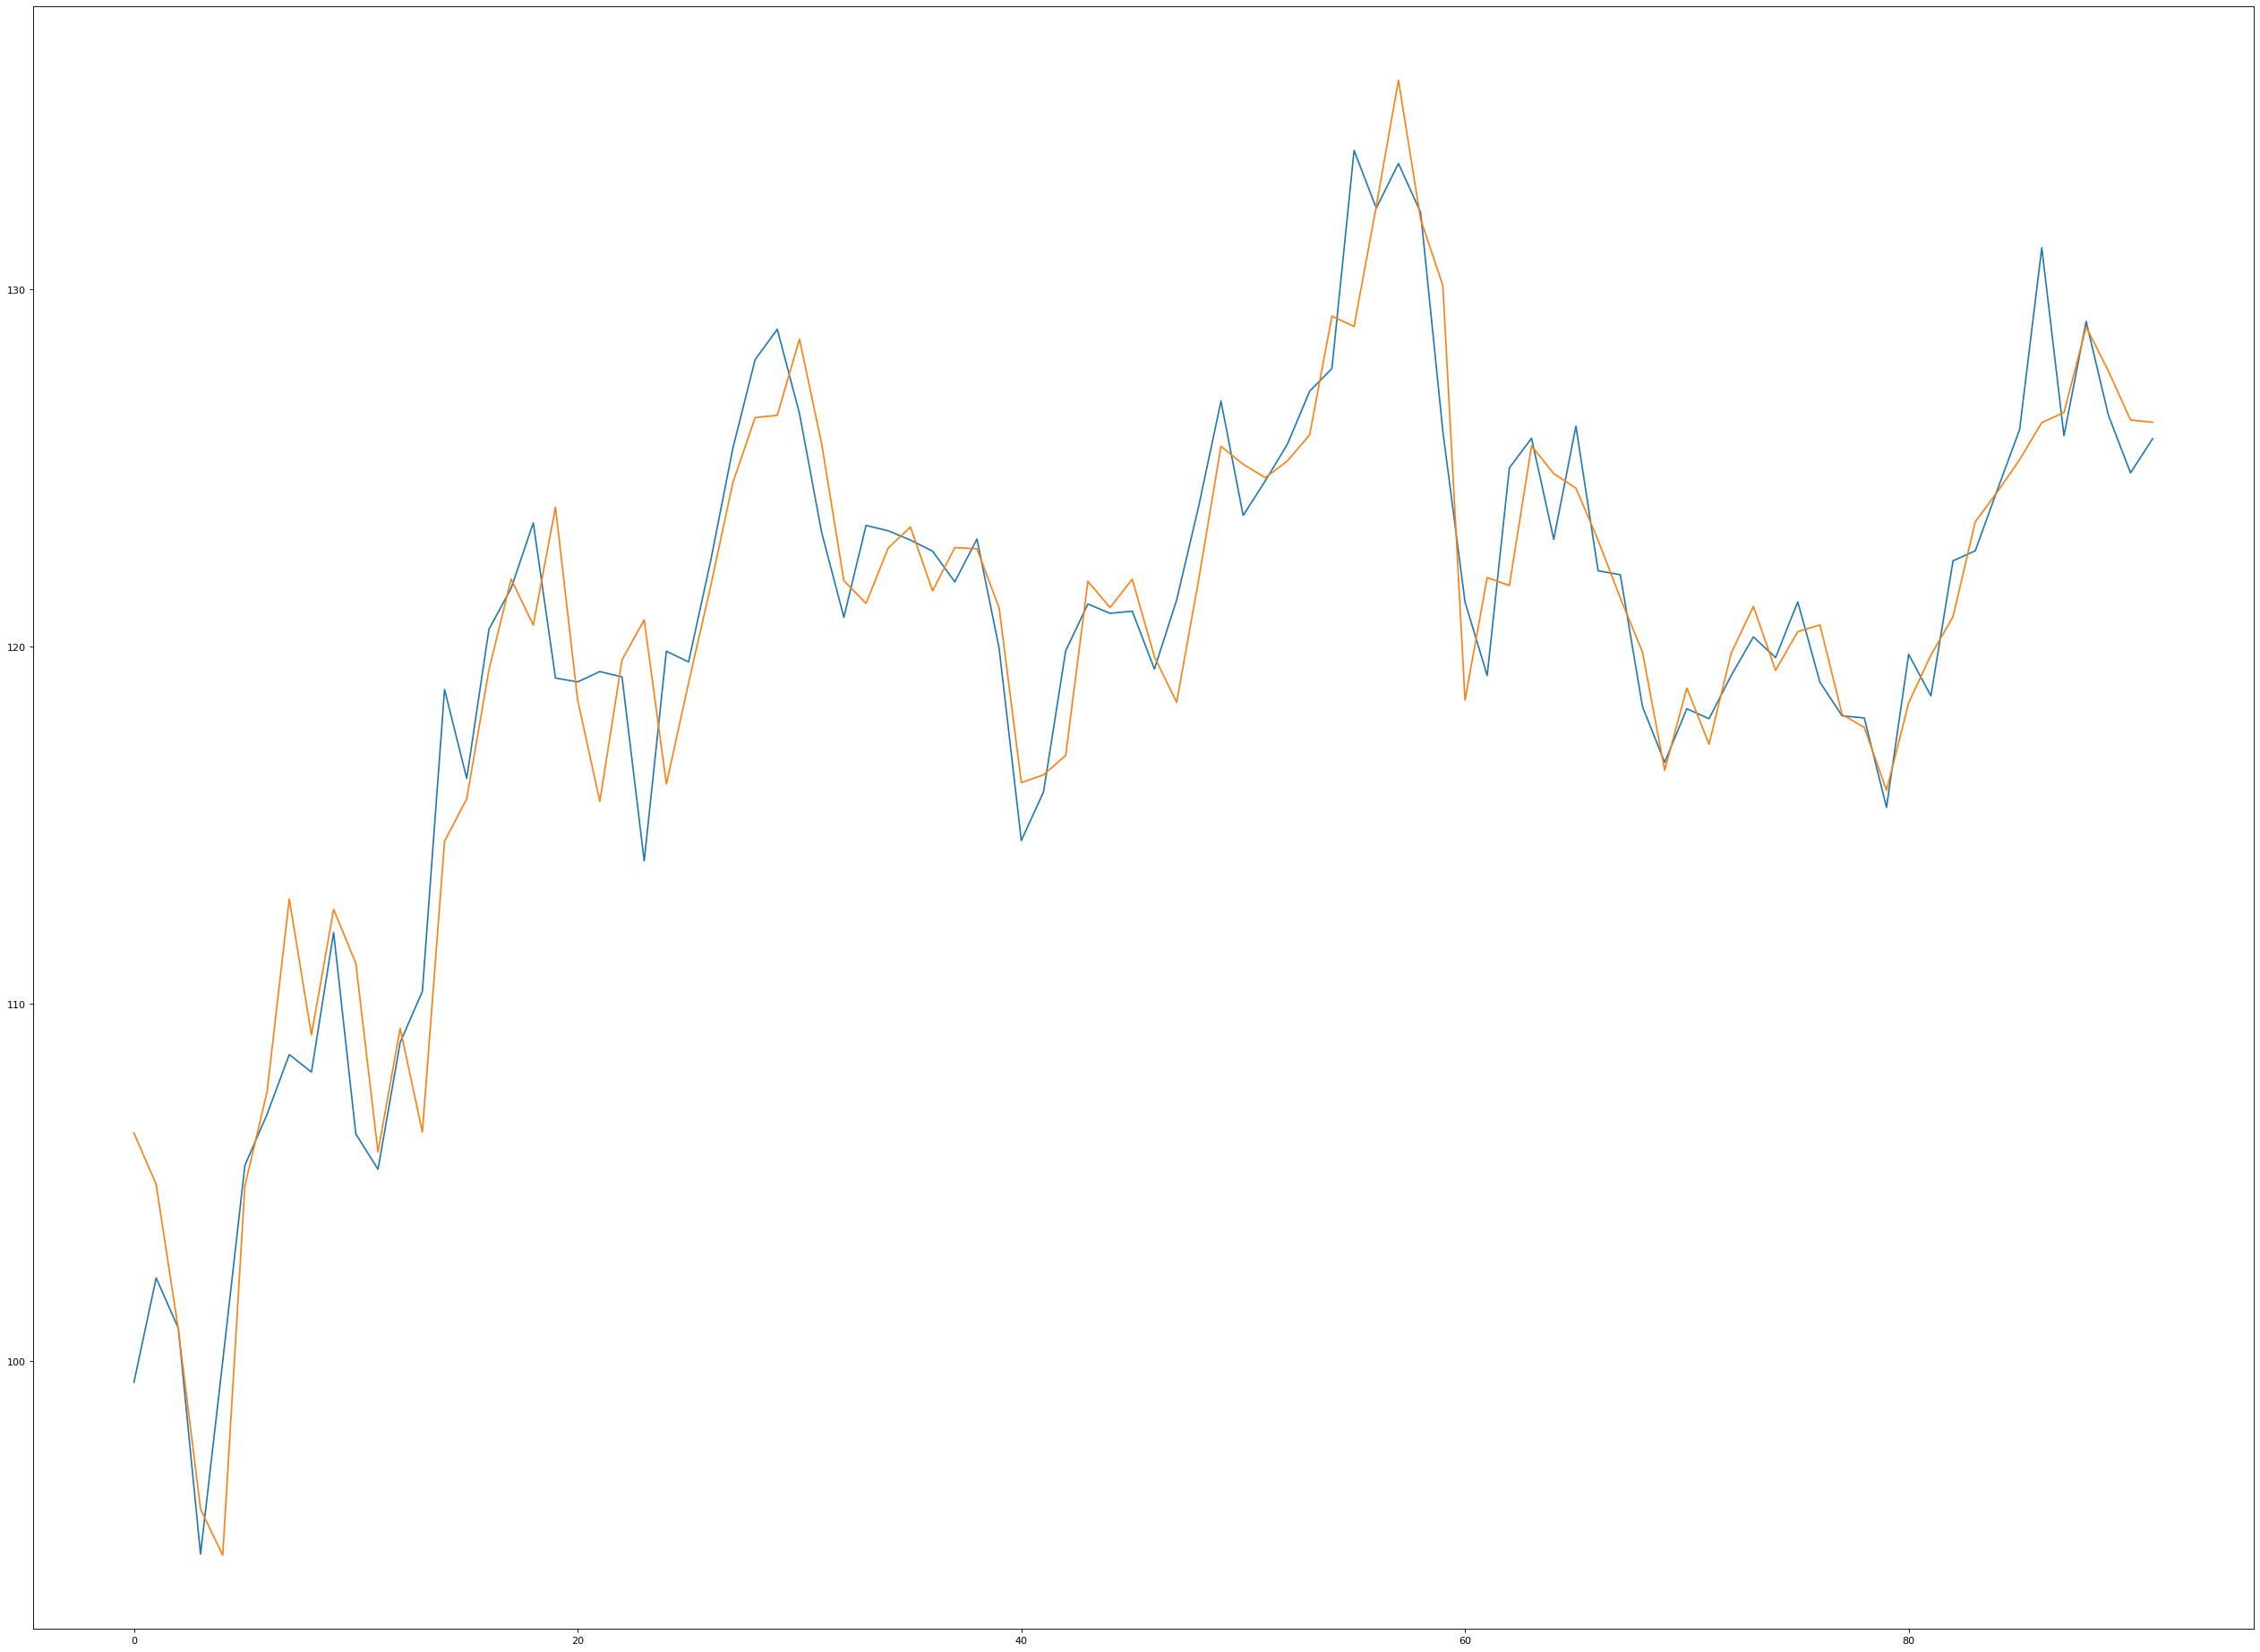

In [30]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()